In [1]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr

In [2]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for iid, _ in user_ratings[:n]]

    return top_n

In [3]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)
data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

train_df, test_df = train_test_split(data_df, test_size=0.2)
U = sorted(train_df["user_id"].unique())

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_df.to_records(index=False)]
raw_testset = [(ruid, riid, r, None) for ruid, riid, r in test_df.to_records(index=False)]
trainset = Dataset.construct_trainset(dataset, raw_trainset)
testset = Dataset.construct_testset(dataset, raw_testset)

# KNN similarity, gain

In [6]:
BEST_K = 5

In [7]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop = UserKNN().compute_popularities(trainset)
gain = UserKNN().compute_gain(trainset)

knn = UserKNN(k=BEST_K, precomputed_sim=sim, precomputed_gain=gain, tau_4=0.5)
knn.fit(trainset)
predictions = knn.test(testset)
mae = accuracy.mae(predictions, verbose=False)

topn = get_top_n(predictions, n=10)

In [8]:
influence = np.zeros(train_df["user_id"].nunique())
s = dt.now()
i = 1
for ruid in train_df["user_id"].unique():
    train_without_u_df = train_df[train_df["user_id"] != ruid]
    raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_without_u_df.to_records(index=False)]
    trainset_without_u = Dataset.construct_trainset(dataset, raw_trainset)
    
    model_without_u = UserKNN(k=BEST_K, precomputed_sim=sim, precomputed_gain=gain, tau_4=0.5)
    model_without_u.fit(trainset_without_u)
    predictions_without_u = model_without_u.test(testset)
    
    topn_without_u = get_top_n(predictions_without_u, n=10)
    jdists = []
    for uid in topn_without_u.keys():
        jdist = 1 - len(set(topn_without_u[uid]).intersection(topn[uid])) / len(set(topn_without_u[uid]).union(topn[uid]))
        jdists.append(jdist)
    influence[ruid] = np.mean(jdists)
    
    print("[%f%% Done] Time elapsed %s, Influence %f" % (100 * i / train_df["user_id"].nunique(), dt.now() - s, influence[ruid]))
    
    i += 1

[0.106045% Done] Time elapsed 0:00:05.829508, Influence 0.291187
[0.212089% Done] Time elapsed 0:00:12.588258, Influence 0.290963
[0.318134% Done] Time elapsed 0:00:19.287646, Influence 0.291044
[0.424178% Done] Time elapsed 0:00:25.500881, Influence 0.291157
[0.530223% Done] Time elapsed 0:00:32.116997, Influence 0.291257
[0.636267% Done] Time elapsed 0:00:38.828041, Influence 0.289225
[0.742312% Done] Time elapsed 0:00:46.104418, Influence 0.289089
[0.848356% Done] Time elapsed 0:00:51.706471, Influence 0.289665
[0.954401% Done] Time elapsed 0:00:57.820144, Influence 0.289811
[1.060445% Done] Time elapsed 0:01:04.233354, Influence 0.288320
[1.166490% Done] Time elapsed 0:01:11.238075, Influence 0.288097
[1.272534% Done] Time elapsed 0:01:17.994566, Influence 0.287506
[1.378579% Done] Time elapsed 0:01:23.718795, Influence 0.287801
[1.484624% Done] Time elapsed 0:01:29.760247, Influence 0.287573
[1.590668% Done] Time elapsed 0:01:36.711785, Influence 0.287789
[1.696713% Done] Time ela

[13.467656% Done] Time elapsed 0:14:50.867055, Influence 0.273947
[13.573701% Done] Time elapsed 0:14:57.149107, Influence 0.273845
[13.679745% Done] Time elapsed 0:15:02.835660, Influence 0.273391
[13.785790% Done] Time elapsed 0:15:08.967017, Influence 0.273492
[13.891835% Done] Time elapsed 0:15:16.244358, Influence 0.273154
[13.997879% Done] Time elapsed 0:15:23.786691, Influence 0.273507
[14.103924% Done] Time elapsed 0:15:30.236802, Influence 0.273760
[14.209968% Done] Time elapsed 0:15:35.806050, Influence 0.274097
[14.316013% Done] Time elapsed 0:15:41.449258, Influence 0.273762
[14.422057% Done] Time elapsed 0:15:47.728741, Influence 0.273444
[14.528102% Done] Time elapsed 0:15:55.306476, Influence 0.273280
[14.634146% Done] Time elapsed 0:16:00.777379, Influence 0.273913
[14.740191% Done] Time elapsed 0:16:06.558155, Influence 0.273103
[14.846235% Done] Time elapsed 0:16:12.981279, Influence 0.273108
[14.952280% Done] Time elapsed 0:16:19.743653, Influence 0.272924
[15.058324

[26.723224% Done] Time elapsed 0:28:45.282745, Influence 0.248876
[26.829268% Done] Time elapsed 0:28:53.630711, Influence 0.249042
[26.935313% Done] Time elapsed 0:29:01.437584, Influence 0.248932
[27.041357% Done] Time elapsed 0:29:09.034365, Influence 0.249809
[27.147402% Done] Time elapsed 0:29:18.338758, Influence 0.247415
[27.253446% Done] Time elapsed 0:29:25.478062, Influence 0.246532
[27.359491% Done] Time elapsed 0:29:31.761017, Influence 0.245695
[27.465536% Done] Time elapsed 0:29:38.957404, Influence 0.244862
[27.571580% Done] Time elapsed 0:29:46.555651, Influence 0.243425
[27.677625% Done] Time elapsed 0:29:54.122567, Influence 0.243352
[27.783669% Done] Time elapsed 0:30:00.528383, Influence 0.243266
[27.889714% Done] Time elapsed 0:30:07.664887, Influence 0.243354
[27.995758% Done] Time elapsed 0:30:16.476465, Influence 0.242950
[28.101803% Done] Time elapsed 0:30:24.528011, Influence 0.243837
[28.207847% Done] Time elapsed 0:30:31.148727, Influence 0.243033
[28.313892

[39.978791% Done] Time elapsed 0:44:42.776805, Influence 0.204682
[40.084836% Done] Time elapsed 0:44:49.153393, Influence 0.204413
[40.190880% Done] Time elapsed 0:44:56.384782, Influence 0.203369
[40.296925% Done] Time elapsed 0:45:04.088228, Influence 0.203384
[40.402969% Done] Time elapsed 0:45:10.912384, Influence 0.203030
[40.509014% Done] Time elapsed 0:45:16.084487, Influence 0.202126
[40.615058% Done] Time elapsed 0:45:21.414068, Influence 0.202287
[40.721103% Done] Time elapsed 0:45:27.328464, Influence 0.202287
[40.827147% Done] Time elapsed 0:45:33.787997, Influence 0.202632
[40.933192% Done] Time elapsed 0:45:40.808695, Influence 0.202411
[41.039236% Done] Time elapsed 0:45:46.518804, Influence 0.202057
[41.145281% Done] Time elapsed 0:45:52.013241, Influence 0.201616
[41.251326% Done] Time elapsed 0:45:58.313748, Influence 0.201069
[41.357370% Done] Time elapsed 0:46:04.968921, Influence 0.200865
[41.463415% Done] Time elapsed 0:46:12.144237, Influence 0.200214
[41.569459

[53.234358% Done] Time elapsed 0:58:44.892256, Influence 0.132837
[53.340403% Done] Time elapsed 0:58:51.823015, Influence 0.132644
[53.446448% Done] Time elapsed 0:58:59.190754, Influence 0.132347
[53.552492% Done] Time elapsed 0:59:08.636520, Influence 0.132318
[53.658537% Done] Time elapsed 0:59:16.682477, Influence 0.131712
[53.764581% Done] Time elapsed 0:59:23.445755, Influence 0.130863
[53.870626% Done] Time elapsed 0:59:31.289203, Influence 0.131081
[53.976670% Done] Time elapsed 0:59:41.047534, Influence 0.130406
[54.082715% Done] Time elapsed 0:59:49.041197, Influence 0.129978
[54.188759% Done] Time elapsed 0:59:55.635741, Influence 0.129978
[54.294804% Done] Time elapsed 1:00:02.770991, Influence 0.129978
[54.400848% Done] Time elapsed 1:00:10.099054, Influence 0.129255
[54.506893% Done] Time elapsed 1:00:18.532342, Influence 0.129255
[54.612937% Done] Time elapsed 1:00:25.644205, Influence 0.129444
[54.718982% Done] Time elapsed 1:00:32.545259, Influence 0.128649
[54.825027

[66.489926% Done] Time elapsed 1:13:30.098412, Influence 0.048797
[66.595970% Done] Time elapsed 1:13:37.216661, Influence 0.048797
[66.702015% Done] Time elapsed 1:13:45.274959, Influence 0.048797
[66.808059% Done] Time elapsed 1:13:52.371247, Influence 0.048990
[66.914104% Done] Time elapsed 1:13:58.803860, Influence 0.048990
[67.020148% Done] Time elapsed 1:14:05.733633, Influence 0.049208
[67.126193% Done] Time elapsed 1:14:13.161986, Influence 0.048501
[67.232238% Done] Time elapsed 1:14:21.502256, Influence 0.048501
[67.338282% Done] Time elapsed 1:14:27.892560, Influence 0.049797
[67.444327% Done] Time elapsed 1:14:34.528272, Influence 0.048829
[67.550371% Done] Time elapsed 1:14:41.766147, Influence 0.048340
[67.656416% Done] Time elapsed 1:14:49.685029, Influence 0.048593
[67.762460% Done] Time elapsed 1:14:56.152397, Influence 0.047898
[67.868505% Done] Time elapsed 1:15:02.847379, Influence 0.047898
[67.974549% Done] Time elapsed 1:15:09.845880, Influence 0.047705
[68.080594

[79.745493% Done] Time elapsed 1:27:41.014802, Influence 0.024692
[79.851538% Done] Time elapsed 1:27:47.895432, Influence 0.023733
[79.957582% Done] Time elapsed 1:27:55.373265, Influence 0.023540
[80.063627% Done] Time elapsed 1:28:02.937857, Influence 0.023540
[80.169671% Done] Time elapsed 1:28:09.196747, Influence 0.023540
[80.275716% Done] Time elapsed 1:28:15.808350, Influence 0.023540
[80.381760% Done] Time elapsed 1:28:23.010627, Influence 0.023540
[80.487805% Done] Time elapsed 1:28:31.091054, Influence 0.023423
[80.593849% Done] Time elapsed 1:28:37.403696, Influence 0.023423
[80.699894% Done] Time elapsed 1:28:44.060144, Influence 0.023423
[80.805938% Done] Time elapsed 1:28:50.778400, Influence 0.023423
[80.911983% Done] Time elapsed 1:28:58.390518, Influence 0.023423
[81.018028% Done] Time elapsed 1:29:05.745735, Influence 0.023231
[81.124072% Done] Time elapsed 1:29:12.233607, Influence 0.023231
[81.230117% Done] Time elapsed 1:29:19.089144, Influence 0.023231
[81.336161

[93.001060% Done] Time elapsed 1:41:44.438739, Influence 0.003787
[93.107105% Done] Time elapsed 1:41:51.259437, Influence 0.003787
[93.213150% Done] Time elapsed 1:41:58.733727, Influence 0.003787
[93.319194% Done] Time elapsed 1:42:05.845875, Influence 0.003891
[93.425239% Done] Time elapsed 1:42:11.922810, Influence 0.003402
[93.531283% Done] Time elapsed 1:42:18.189131, Influence 0.003538
[93.637328% Done] Time elapsed 1:42:25.024706, Influence 0.003048
[93.743372% Done] Time elapsed 1:42:32.634947, Influence 0.003048
[93.849417% Done] Time elapsed 1:42:38.398603, Influence 0.002663
[93.955461% Done] Time elapsed 1:42:44.777040, Influence 0.002116
[94.061506% Done] Time elapsed 1:42:51.491628, Influence 0.002116
[94.167550% Done] Time elapsed 1:42:58.698517, Influence 0.002116
[94.273595% Done] Time elapsed 1:43:05.537707, Influence 0.002116
[94.379639% Done] Time elapsed 1:43:11.522559, Influence 0.002116
[94.485684% Done] Time elapsed 1:43:17.982544, Influence 0.002116
[94.591729

Text(0.5, 1.0, 'Spearman Rank Correlation 0.0756 (p-value: 0.02)')

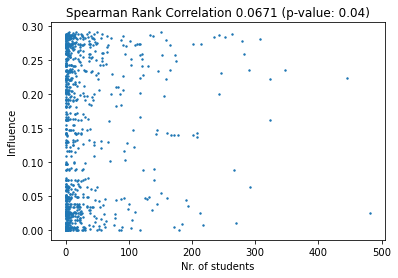

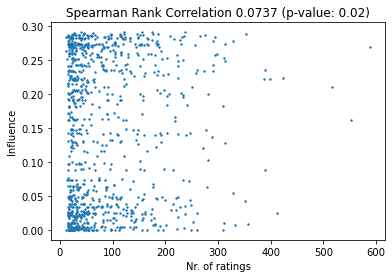

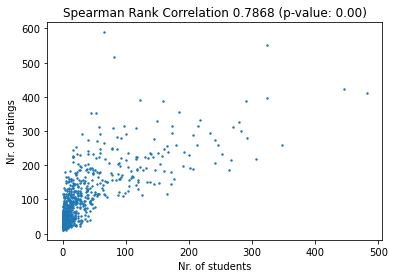

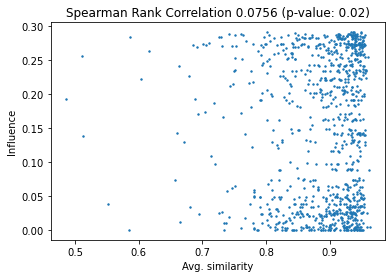

In [9]:
n_students = []
for ruid in train_df["user_id"].unique():
    iuid = trainset.to_inner_uid(ruid)
    deg = len(knn.students[iuid])
    n_students.append(deg)
n_students = np.array(n_students)

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, influence, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

n_ratings = train_df.groupby("user_id").size().loc[train_df["user_id"].unique()].values
r, p = spearmanr(n_ratings, influence)
plt.figure()
plt.scatter(n_ratings, influence, s=2)
plt.xlabel("Nr. of ratings")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

r, p = spearmanr(n_students, n_ratings)
plt.figure()
plt.scatter(n_students, n_ratings, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Nr. of ratings")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

avg_similarity = np.mean(sim, axis=0)[[trainset.to_inner_uid(ruid) for ruid in train_df["user_id"].unique()]]
r, p = spearmanr(avg_similarity, influence)
plt.figure()
plt.scatter(avg_similarity, influence, s=2)
plt.xlabel("Avg. similarity")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

In [10]:
top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[0], reverse=True)[:10]
print("[Avg. Influence] Highest degree mentors: %0.4f, All mentors: %0.4f" % (np.mean([infl for deg, infl in top_mentors]), np.mean(influence)))

top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[1], reverse=True)[:10]
print("[Avg. Degree] Highest influential mentors: %0.4f, All mentors: %0.4f" % (np.mean([deg for deg, infl in top_mentors]), np.mean(n_students)))

[Avg. Influence] Highest degree mentors: 0.1987, All mentors: 0.1442
[Avg. Degree] Highest influential mentors: 32.0000, All mentors: 28.3171


# KNN similarity, gain, reuse

In [11]:
BEST_K = 7

In [12]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop = UserKNN().compute_popularities(trainset)
gain = UserKNN().compute_gain(trainset)

knn = UserKNN(k=BEST_K, precomputed_sim=sim, reuse=True, precomputed_gain=gain, tau_4=0.5)
knn.fit(trainset)
predictions = knn.test(testset)
mae = accuracy.mae(predictions, verbose=False)

topn = get_top_n(predictions, n=10)

In [13]:
influence = np.zeros(train_df["user_id"].nunique())
s = dt.now()
i = 1
for ruid in train_df["user_id"].unique():
    train_without_u_df = train_df[train_df["user_id"] != ruid]
    raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_without_u_df.to_records(index=False)]
    trainset_without_u = Dataset.construct_trainset(dataset, raw_trainset)
    
    model_without_u = UserKNN(k=BEST_K, precomputed_sim=sim, reuse=True, precomputed_gain=gain, tau_4=0.5)
    model_without_u.fit(trainset_without_u)
    predictions_without_u = model_without_u.test(testset)
    
    topn_without_u = get_top_n(predictions_without_u, n=10)
    jdists = []
    for uid in topn_without_u.keys():
        jdist = 1 - len(set(topn_without_u[uid]).intersection(topn[uid])) / len(set(topn_without_u[uid]).union(topn[uid]))
        jdists.append(jdist)
    influence[ruid] = np.mean(jdists)
    
    print("[%f%% Done] Time elapsed %s, Influence %f" % (100 * i / train_df["user_id"].nunique(), dt.now() - s, influence[ruid]))
    
    i += 1

[0.106045% Done] Time elapsed 0:00:06.886478, Influence 0.269304
[0.212089% Done] Time elapsed 0:00:14.440101, Influence 0.267279
[0.318134% Done] Time elapsed 0:00:20.390593, Influence 0.266903
[0.424178% Done] Time elapsed 0:00:26.693598, Influence 0.267271
[0.530223% Done] Time elapsed 0:00:33.519004, Influence 0.266814
[0.636267% Done] Time elapsed 0:00:41.083909, Influence 0.266552
[0.742312% Done] Time elapsed 0:00:46.883045, Influence 0.265837
[0.848356% Done] Time elapsed 0:00:53.013283, Influence 0.265182
[0.954401% Done] Time elapsed 0:00:59.711547, Influence 0.266969
[1.060445% Done] Time elapsed 0:01:07.575531, Influence 0.267041
[1.166490% Done] Time elapsed 0:01:13.950902, Influence 0.266262
[1.272534% Done] Time elapsed 0:01:20.110813, Influence 0.266472
[1.378579% Done] Time elapsed 0:01:26.685497, Influence 0.266032
[1.484624% Done] Time elapsed 0:01:33.417643, Influence 0.265899
[1.590668% Done] Time elapsed 0:01:40.181680, Influence 0.266218
[1.696713% Done] Time ela

[13.467656% Done] Time elapsed 0:13:48.710336, Influence 0.255151
[13.573701% Done] Time elapsed 0:13:55.280324, Influence 0.254899
[13.679745% Done] Time elapsed 0:14:02.622844, Influence 0.253576
[13.785790% Done] Time elapsed 0:14:08.675601, Influence 0.254389
[13.891835% Done] Time elapsed 0:14:14.752863, Influence 0.253495
[13.997879% Done] Time elapsed 0:14:21.328793, Influence 0.253625
[14.103924% Done] Time elapsed 0:14:28.424295, Influence 0.254489
[14.209968% Done] Time elapsed 0:14:34.626092, Influence 0.255070
[14.316013% Done] Time elapsed 0:14:40.728621, Influence 0.253628
[14.422057% Done] Time elapsed 0:14:47.175262, Influence 0.254601
[14.528102% Done] Time elapsed 0:14:54.683858, Influence 0.254594
[14.634146% Done] Time elapsed 0:15:01.141394, Influence 0.254129
[14.740191% Done] Time elapsed 0:15:07.171285, Influence 0.254100
[14.846235% Done] Time elapsed 0:15:13.361120, Influence 0.254682
[14.952280% Done] Time elapsed 0:15:20.456143, Influence 0.254541
[15.058324

[26.723224% Done] Time elapsed 0:27:37.786073, Influence 0.237264
[26.829268% Done] Time elapsed 0:27:43.853045, Influence 0.237264
[26.935313% Done] Time elapsed 0:27:51.152107, Influence 0.237765
[27.041357% Done] Time elapsed 0:27:58.148837, Influence 0.237260
[27.147402% Done] Time elapsed 0:28:05.953102, Influence 0.237323
[27.253446% Done] Time elapsed 0:28:12.065434, Influence 0.234672
[27.359491% Done] Time elapsed 0:28:18.212183, Influence 0.235059
[27.465536% Done] Time elapsed 0:28:25.326891, Influence 0.234095
[27.571580% Done] Time elapsed 0:28:33.005765, Influence 0.234082
[27.677625% Done] Time elapsed 0:28:39.273959, Influence 0.233994
[27.783669% Done] Time elapsed 0:28:45.933682, Influence 0.233696
[27.889714% Done] Time elapsed 0:28:52.799605, Influence 0.233441
[27.995758% Done] Time elapsed 0:29:00.833311, Influence 0.233441
[28.101803% Done] Time elapsed 0:29:06.610711, Influence 0.233839
[28.207847% Done] Time elapsed 0:29:13.112995, Influence 0.234719
[28.313892

[39.978791% Done] Time elapsed 0:41:35.522594, Influence 0.203567
[40.084836% Done] Time elapsed 0:41:42.297301, Influence 0.203866
[40.190880% Done] Time elapsed 0:41:49.971966, Influence 0.203920
[40.296925% Done] Time elapsed 0:41:56.298892, Influence 0.204066
[40.402969% Done] Time elapsed 0:42:02.394514, Influence 0.203586
[40.509014% Done] Time elapsed 0:42:09.150146, Influence 0.203230
[40.615058% Done] Time elapsed 0:42:16.689180, Influence 0.203600
[40.721103% Done] Time elapsed 0:42:23.532267, Influence 0.202556
[40.827147% Done] Time elapsed 0:42:29.700481, Influence 0.202315
[40.933192% Done] Time elapsed 0:42:36.165687, Influence 0.201513
[41.039236% Done] Time elapsed 0:42:43.478922, Influence 0.202282
[41.145281% Done] Time elapsed 0:42:50.559083, Influence 0.201189
[41.251326% Done] Time elapsed 0:42:56.584659, Influence 0.201635
[41.357370% Done] Time elapsed 0:43:02.864322, Influence 0.202139
[41.463415% Done] Time elapsed 0:43:09.992116, Influence 0.202362
[41.569459

[53.234358% Done] Time elapsed 0:54:19.656405, Influence 0.152867
[53.340403% Done] Time elapsed 0:54:25.655949, Influence 0.151991
[53.446448% Done] Time elapsed 0:54:31.361255, Influence 0.152713
[53.552492% Done] Time elapsed 0:54:36.459198, Influence 0.148523
[53.658537% Done] Time elapsed 0:54:41.982146, Influence 0.148324
[53.764581% Done] Time elapsed 0:54:47.820302, Influence 0.147270
[53.870626% Done] Time elapsed 0:54:52.621774, Influence 0.147245
[53.976670% Done] Time elapsed 0:54:57.743158, Influence 0.147964
[54.082715% Done] Time elapsed 0:55:02.913228, Influence 0.147579
[54.188759% Done] Time elapsed 0:55:08.575989, Influence 0.146968
[54.294804% Done] Time elapsed 0:55:14.097100, Influence 0.147588
[54.400848% Done] Time elapsed 0:55:19.046214, Influence 0.147588
[54.506893% Done] Time elapsed 0:55:24.373967, Influence 0.147427
[54.612937% Done] Time elapsed 0:55:30.020933, Influence 0.147427
[54.718982% Done] Time elapsed 0:55:35.821849, Influence 0.147427
[54.825027

[66.489926% Done] Time elapsed 1:05:46.312005, Influence 0.075504
[66.595970% Done] Time elapsed 1:05:52.474899, Influence 0.073446
[66.702015% Done] Time elapsed 1:05:58.799770, Influence 0.073583
[66.808059% Done] Time elapsed 1:06:06.141101, Influence 0.073032
[66.914104% Done] Time elapsed 1:06:12.916162, Influence 0.072895
[67.020148% Done] Time elapsed 1:06:18.851006, Influence 0.072895
[67.126193% Done] Time elapsed 1:06:25.238352, Influence 0.073227
[67.232238% Done] Time elapsed 1:06:32.418395, Influence 0.073032
[67.338282% Done] Time elapsed 1:06:39.484163, Influence 0.073032
[67.444327% Done] Time elapsed 1:06:45.408372, Influence 0.073252
[67.550371% Done] Time elapsed 1:06:51.626366, Influence 0.072539
[67.656416% Done] Time elapsed 1:06:58.508225, Influence 0.072539
[67.762460% Done] Time elapsed 1:07:05.519229, Influence 0.072701
[67.868505% Done] Time elapsed 1:07:11.814478, Influence 0.071827
[67.974549% Done] Time elapsed 1:07:18.261515, Influence 0.071633
[68.080594

[79.745493% Done] Time elapsed 1:19:41.599194, Influence 0.029492
[79.851538% Done] Time elapsed 1:19:47.817695, Influence 0.027136
[79.957582% Done] Time elapsed 1:19:54.328381, Influence 0.027136
[80.063627% Done] Time elapsed 1:20:01.883815, Influence 0.027492
[80.169671% Done] Time elapsed 1:20:08.208612, Influence 0.027136
[80.275716% Done] Time elapsed 1:20:14.165738, Influence 0.027136
[80.381760% Done] Time elapsed 1:20:20.455893, Influence 0.026939
[80.487805% Done] Time elapsed 1:20:27.554273, Influence 0.026137
[80.593849% Done] Time elapsed 1:20:34.583142, Influence 0.026137
[80.699894% Done] Time elapsed 1:20:40.677148, Influence 0.026332
[80.805938% Done] Time elapsed 1:20:47.276921, Influence 0.025198
[80.911983% Done] Time elapsed 1:20:54.106647, Influence 0.024900
[81.018028% Done] Time elapsed 1:21:01.702805, Influence 0.024543
[81.124072% Done] Time elapsed 1:21:07.512779, Influence 0.024155
[81.230117% Done] Time elapsed 1:21:13.794493, Influence 0.023662
[81.336161

[93.001060% Done] Time elapsed 1:31:56.765389, Influence 0.002986
[93.107105% Done] Time elapsed 1:32:02.255578, Influence 0.002986
[93.213150% Done] Time elapsed 1:32:08.236002, Influence 0.003641
[93.319194% Done] Time elapsed 1:32:14.369768, Influence 0.002655
[93.425239% Done] Time elapsed 1:32:19.846229, Influence 0.002299
[93.531283% Done] Time elapsed 1:32:25.234579, Influence 0.002299
[93.637328% Done] Time elapsed 1:32:30.876544, Influence 0.002299
[93.743372% Done] Time elapsed 1:32:36.480623, Influence 0.002299
[93.849417% Done] Time elapsed 1:32:41.520718, Influence 0.002299
[93.955461% Done] Time elapsed 1:32:46.810183, Influence 0.002299
[94.061506% Done] Time elapsed 1:32:52.326505, Influence 0.002493
[94.167550% Done] Time elapsed 1:32:58.096309, Influence 0.002299
[94.273595% Done] Time elapsed 1:33:03.843829, Influence 0.002493
[94.379639% Done] Time elapsed 1:33:09.106478, Influence 0.002493
[94.485684% Done] Time elapsed 1:33:14.752276, Influence 0.002493
[94.591729

Text(0.5, 1.0, 'Spearman Rank Correlation -0.0027 (p-value: 0.93)')

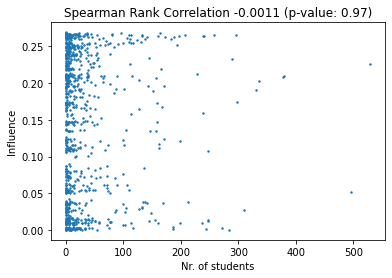

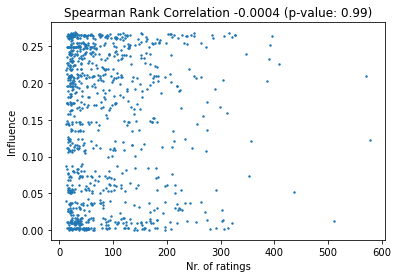

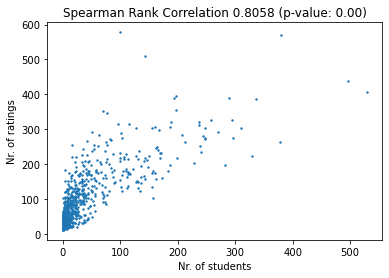

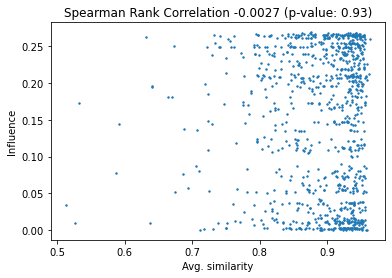

In [14]:
n_students = []
for ruid in train_df["user_id"].unique():
    iuid = trainset.to_inner_uid(ruid)
    deg = len(knn.students[iuid])
    n_students.append(deg)
n_students = np.array(n_students)

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, influence, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

n_ratings = train_df.groupby("user_id").size().loc[train_df["user_id"].unique()].values
r, p = spearmanr(n_ratings, influence)
plt.figure()
plt.scatter(n_ratings, influence, s=2)
plt.xlabel("Nr. of ratings")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

r, p = spearmanr(n_students, n_ratings)
plt.figure()
plt.scatter(n_students, n_ratings, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Nr. of ratings")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

avg_similarity = np.mean(sim, axis=0)[[trainset.to_inner_uid(ruid) for ruid in train_df["user_id"].unique()]]
r, p = spearmanr(avg_similarity, influence)
plt.figure()
plt.scatter(avg_similarity, influence, s=2)
plt.xlabel("Avg. similarity")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

In [15]:
top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[0], reverse=True)[:10]
print("[Avg. Influence] Highest degree mentors: %0.4f, All mentors: %0.4f" % (np.mean([infl for deg, infl in top_mentors]), np.mean(influence)))

top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[1], reverse=True)[:10]
print("[Avg. Degree] Highest influential mentors: %0.4f, All mentors: %0.4f" % (np.mean([deg for deg, infl in top_mentors]), np.mean(n_students)))

[Avg. Influence] Highest degree mentors: 0.1789, All mentors: 0.1458
[Avg. Degree] Highest influential mentors: 34.3000, All mentors: 31.1548


In [18]:
print(np.mean(n_students), np.median(n_students), np.percentile(n_students, 62))

31.154825026511134 8.0 16.0


In [40]:
sum(influence)

137.52228853200063

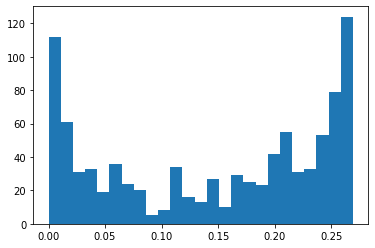

In [20]:
plt.hist(influence, bins=25);

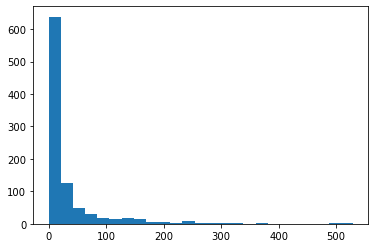

In [22]:
plt.hist(n_students, bins=25);

In [31]:
np.percentile(n_students, 76)

33.91999999999996

In [43]:
top_influencers = np.argsort(n_students)[-10:]
top_influencers_df = train_df[train_df["user_id"].isin(top_influencers)]
top_influencers_df.groupby("user_id").size().mean(), train_df.groupby("user_id").size().mean()

(81.1, 84.83457051961824)

In [42]:
top_mentors = np.argsort(n_students)[-10:]
np.mean(avg_similarity[top_mentors]), np.mean(avg_similarity)

(0.9522440411126813, 0.8906554702167837)